In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
df.nunique()

longitude               844
latitude                862
housing_median_age       52
total_rooms            5926
total_bedrooms         1923
population             3888
households             1815
median_income         12928
median_house_value     3842
ocean_proximity           5
dtype: int64

In [5]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
df.total_bedrooms.fillna(0, inplace=True)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [7]:
df.ocean_proximity = df.ocean_proximity.str.lower().str.replace(' ', '_')

In [8]:
df.ocean_proximity.value_counts()

<1h_ocean     9136
inland        6551
near_ocean    2658
near_bay      2290
island           5
Name: ocean_proximity, dtype: int64

In [9]:
df['rooms_per_household'] = df.total_rooms / df.households
df['bedrooms_per_room'] = df.total_bedrooms / df.total_rooms
df['population_per_household'] = df.population / df.households

#### Ocean proximity

In [10]:
f"Most frequent observation (mode) for the column ocean_proximity: {df.ocean_proximity.mode()[0]}"

'Most frequent observation (mode) for the column ocean_proximity: <1h_ocean'

#### Splitting data

In [11]:
from sklearn.model_selection import train_test_split

dfTrainFull, dfTest = train_test_split(
    df, test_size=0.2, random_state=42)

# Splitting the data
dfTrain, dfVal = train_test_split(
    dfTrainFull, test_size=0.25, random_state=42)

print(len(dfTrain), len(dfVal), len(dfTest))

12384 4128 4128


#### Correlation

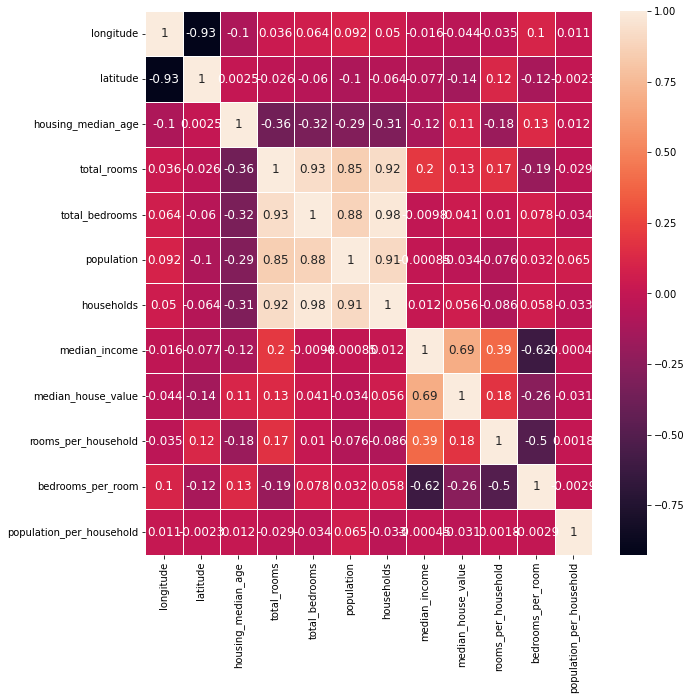

In [12]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
_ = sns.heatmap(dfTrain.corr(), annot=True, linewidths=1,annot_kws={"size":12})

**Households and total bedrooms** have the hights correlation

#### Make median_house_value binary

In [13]:
valueMean = dfTrain.median_house_value.mean()
dfTrain['above_average'] = (dfTrain.median_house_value > valueMean).astype(int)
dfVal['above_average'] = (dfVal.median_house_value > valueMean).astype(int)
dfTest['above_average'] = (dfTest.median_house_value > valueMean).astype(int)

#### mutual information score between categorical variable and above_score

In [14]:
from sklearn.metrics import mutual_info_score

In [15]:
MIScore = mutual_info_score(dfTrain.above_average, dfTrain.ocean_proximity)
round(MIScore,3)

0.101

Mutual information score between 'above_average' and 'ocean_proximity' = **0.101**

#### One-Hot_Encoding

In [16]:
targetCol = 'above_average'
dfTrain.reset_index(drop=True, inplace=True)
dfVal.reset_index(drop=True, inplace=True)
dfTest.reset_index(drop=True, inplace=True)

yTrain = dfTrain[targetCol].values
yVal = dfVal[targetCol].values
yTest = dfTest[targetCol].values

targetColNum = 'median_house_value'
del dfTrain[targetColNum]
del dfVal[targetColNum]
del dfTest[targetColNum]

del dfTrain[targetCol]
del dfVal[targetCol]
del dfTest[targetCol]

In [17]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

catPreprocessor = OneHotEncoder(handle_unknown="ignore")
numPreprocessor = StandardScaler()

categoricalColumns = ['ocean_proximity']

In [18]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('one-hot-encoder', catPreprocessor, categoricalColumns)],remainder="passthrough")

#### Training the model

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(preprocessor, LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42))

In [20]:
dfTrain.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'rooms_per_household', 'bedrooms_per_room',
       'population_per_household'],
      dtype='object')

In [21]:
_ = model.fit(dfTrain, yTrain)
model.predict(dfVal)[:5]

array([0, 0, 1, 0, 1])

In [22]:
accuracy = model.score(dfVal, yVal)
round(model.score(dfVal, yVal), 2)

0.84

**Logistic Regression accuracy: 0.84**

In [31]:
# Fiding least usful feature 

numericalColumns = list(dfTrain.columns.drop('ocean_proximity'))

allColumns = categoricalColumns + numericalColumns

allColumns

['ocean_proximity',
 'longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_room',
 'population_per_household']

In [33]:
totalColumns = allColumns[:]
lenCols = len(totalColumns)
accs = []
minx = {}
for i in range(1,lenCols):
    col = totalColumns[i]
    if col in ['total_rooms', 'total_bedrooms', 'population', 'households']:
        totalColumns.pop(i)
        _ = model.fit(dfTrain[totalColumns], yTrain)
        newacc = model.score(dfVal[totalColumns], yVal)
        diff = abs(newacc - accuracy)
        print(f'{col} - difference {diff}')
        totalColumns = allColumns[:]
    
    

total_rooms - difference 0.001211240310077466
total_bedrooms - difference 0.00024224806201555982
population - difference 0.009447674418604723
households - difference 0.0021802325581395943


Smallest difference **total_bedrooms - diff = 0.00024224806201555982**

#### Let's try linear regression with different alphas

In [34]:
# Splitting dataset
dataFull, dataTest = train_test_split(
    df, test_size=0.2, random_state=42)

# Splitting the data
dataTrain, dataVal = train_test_split(
    dataFull, test_size=0.25, random_state=42)

print(len(dataTrain), len(dataVal), len(dataTest))

12384 4128 4128


In [35]:
# Creating target values
targetTrain = np.log1p(dataTrain['median_house_value'].values)
targetVal = np.log1p(dataVal['median_house_value'].values)
targetTest = np.log1p(dataTest['median_house_value'].values)

del dataTrain['median_house_value']
del dataVal['median_house_value']
del dataTest['median_house_value']

In [36]:
# Creating preprocesors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
catPreprocessor = OneHotEncoder(handle_unknown="ignore")
#numPreprocessor = StandardScaler()

In [37]:
# Transforming the data
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('one-hot-encoder', catPreprocessor, categoricalColumns)], remainder="passthrough")

In [38]:
# creating the model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

modelNew = make_pipeline(preprocessor, Ridge(solver="sag", random_state=42))

In [39]:
# Printing available parameters for the model
for p in modelNew.get_params():
    print(p)


memory
steps
verbose
columntransformer
ridge
columntransformer__n_jobs
columntransformer__remainder
columntransformer__sparse_threshold
columntransformer__transformer_weights
columntransformer__transformers
columntransformer__verbose
columntransformer__one-hot-encoder
columntransformer__one-hot-encoder__categories
columntransformer__one-hot-encoder__drop
columntransformer__one-hot-encoder__dtype
columntransformer__one-hot-encoder__handle_unknown
columntransformer__one-hot-encoder__sparse
ridge__alpha
ridge__copy_X
ridge__fit_intercept
ridge__max_iter
ridge__normalize
ridge__random_state
ridge__solver
ridge__tol


In [ ]:
# Running model for differents values of alpha
results = {}
alphas = [0, 0.01, 0.1, 1, 10]

for alpha in alphas:
    modelNew.set_params(ridge__alpha = alpha)
    _ = modelNew.fit(dataTrain, targetTrain)
    yPred = modelNew.predict(dataVal)
    rmse = round(mean_squared_error(targetVal, yPred, squared=False),3)
    results[alpha] = rmse
    print(f"#### alpha = {alpha}, RMSE = {rmse} ####\n")

#### alpha = 0, RMSE = 0.524 ####

#### alpha = 0.01, RMSE = 0.524 ####

#### alpha = 0.1, RMSE = 0.524 ####



**Same accuracy for all the alphas**